In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import harmonypy
import pymn
import scrublet as scr
import gseapy as gp
from gseapy.plot import barplot, dotplot
import bottleneck
import pyreadr
from scipy.io import mmread
import scipy
from sklearn import preprocessing
import random as rd
import scib
from matplotlib_venn import venn2,venn2_circles,venn3
from pyscenic.export import export2loom, add_scenic_metadata
from sklearn.decomposition import NMF
from sklearn import metrics
import palettable
from pyscenic.rss import regulon_specificity_scores
import matplotlib.image as mpimg
import cosg as cosg
from pySankey.sankey import sankey

import matplotlib as mpl

from pyscenic.utils import modules_from_adjacencies
from IPython.display import display, Image


In [4]:
sc.set_figure_params(dpi = 200, color_map = 'viridis_r' )
sc.settings.verbosity = 2

In [7]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [31]:
p_cutoff = 0.05
logFC_cutoff = 0

adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cancer_module/cnv_high_epi_harmony/cnv_high_epi_harmony_anno_latest.h5ad')
adata = adata[adata.obs['leiden'] == '10']

patient_list = []

for each_patient in np.unique(adata.obs['study_id']).tolist():
    
    if adata[adata.obs['study_id'] == each_patient].shape[0] > 2:
                
        patient_list.append(each_patient)

marker_dict = {}
        
for SCENIC_subset_selected in ['SCENIC_Epithelium_subset_1', 'SCENIC_Epithelium_subset_2', 
                               'SCENIC_Epithelium_subset_3']:
    
    all_marker = pd.DataFrame()
    
    for each_patient in patient_list:

        each_seurat = pd.read_csv('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cancer_module/malignant_ciliated/ciliated_specific_TF/' + each_patient + '_' + SCENIC_subset_selected + '_high_ciliated_TF.csv', index_col=0)

        each_seurat = each_seurat[each_seurat['p_val_adj'] < p_cutoff]
        each_seurat = each_seurat[each_seurat['avg_log2FC'] > logFC_cutoff]

        each_seurat['patient'] = each_patient
        each_seurat['cancer_type'] = each_patient.split('_')[0]
        each_seurat['subset'] = SCENIC_subset_selected

        all_marker = pd.concat([each_seurat, all_marker], axis=0)

    all_marker['gene'] = all_marker.index

    gene_stat = pd.DataFrame(index=np.unique(all_marker['gene']).tolist())

    for each_gene in gene_stat.index.tolist():

        gene_stat.loc[each_gene, 'n_patient'] = len(np.unique(all_marker[all_marker['gene'] == each_gene]['patient']))
        gene_stat.loc[each_gene, 'n_cancer'] = len(np.unique(all_marker[all_marker['gene'] == each_gene]['cancer_type']))

    gene_stat['ranking'] = gene_stat['n_cancer']*100 + gene_stat['n_patient']
    gene_stat = gene_stat.sort_values('ranking', ascending=False)

    gene_stat = gene_stat[gene_stat['ranking'] >= 305]

    marker_dict[SCENIC_subset_selected] = gene_stat.index.tolist()
    
test_inter = list(set(marker_dict['SCENIC_Epithelium_subset_1']).intersection(set(marker_dict['SCENIC_Epithelium_subset_2'])))
test_inter = list(set(test_inter).intersection(set(marker_dict['SCENIC_Epithelium_subset_3'])))

test_inter

['MYB(+)', 'RFX3(+)', 'RFX2(+)', 'FOXN4(+)', 'E2F7(+)']

# Down-Regulation of RFX3 (High vs Low)

In [28]:
SCENIC_Epithelium_1 = pd.read_csv('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/SCENIC/SCENIC_Epithelium_subset_1/SCENIC_Epithelium_subset_1_SCENIC.csv', index_col=0)
SCENIC_Epithelium_2 = pd.read_csv('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/SCENIC/SCENIC_Epithelium_subset_2/SCENIC_Epithelium_subset_2_SCENIC.csv', index_col=0)
SCENIC_Epithelium_3 = pd.read_csv('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/SCENIC/SCENIC_Epithelium_subset_3/SCENIC_Epithelium_subset_3_SCENIC.csv', index_col=0)


In [29]:
adata_high = sc.read('ciliated_cnv_obs_high.h5ad')
adata_low = sc.read('ciliated_cnv_obs_low.h5ad')

adata = sc.AnnData.concatenate(adata_high, adata_low,
                           join = "outer", fill_value = 0, index_unique = None)

adata.obs['study_id'] = adata.obs['study_id'].astype(str)
adata.obs['cancer_type'] = adata.obs['cancer_type'].astype(str)
adata.obs['cnv_cluster_type'] = adata.obs['cnv_cluster_type'].astype(str)
adata.obs['cnv_patient'] = adata.obs['cnv_cluster_type'] + '_' + adata.obs['study_id']

#SCENIC_results = SCENIC_Epithelium_1.loc[adata.obs.index.tolist(), :].copy()
SCENIC_results = SCENIC_Epithelium_2.loc[adata.obs.index.tolist(), :].copy()
#SCENIC_results = SCENIC_Epithelium_3.loc[adata.obs.index.tolist(), :].copy()
SCENIC_adata = sc.AnnData(SCENIC_results)
SCENIC_adata.obs['cnv_cluster_type'] = adata.obs['cnv_cluster_type']
SCENIC_adata.obs['cancer_type'] = adata.obs['cancer_type']
    
sc.pp.scale(SCENIC_adata)

/public/home/guogjgroup/ggj/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/tmp/ipykernel_26438/3716496584.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  SCENIC_adata = sc.AnnData(SCENIC_results)


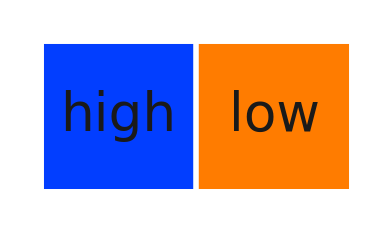

In [30]:
cats = np.unique(SCENIC_adata.obs['cnv_cluster_type'])

colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in SCENIC_adata.obs['cnv_cluster_type'] ]

sns.set()
sns.set(font_scale=0.8)
fig = palplot(colors, cats, size=0.5)
plt.savefig('figures/malignant_normal_ciliated_TF_legend.pdf')

In [31]:
#['TCF7L2(+)', 'REL(+)', 'ELF1(+)', 'BPTF(+)', 'E2F3(+)', 'ETS1(+)', 'RFX3(+)']

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


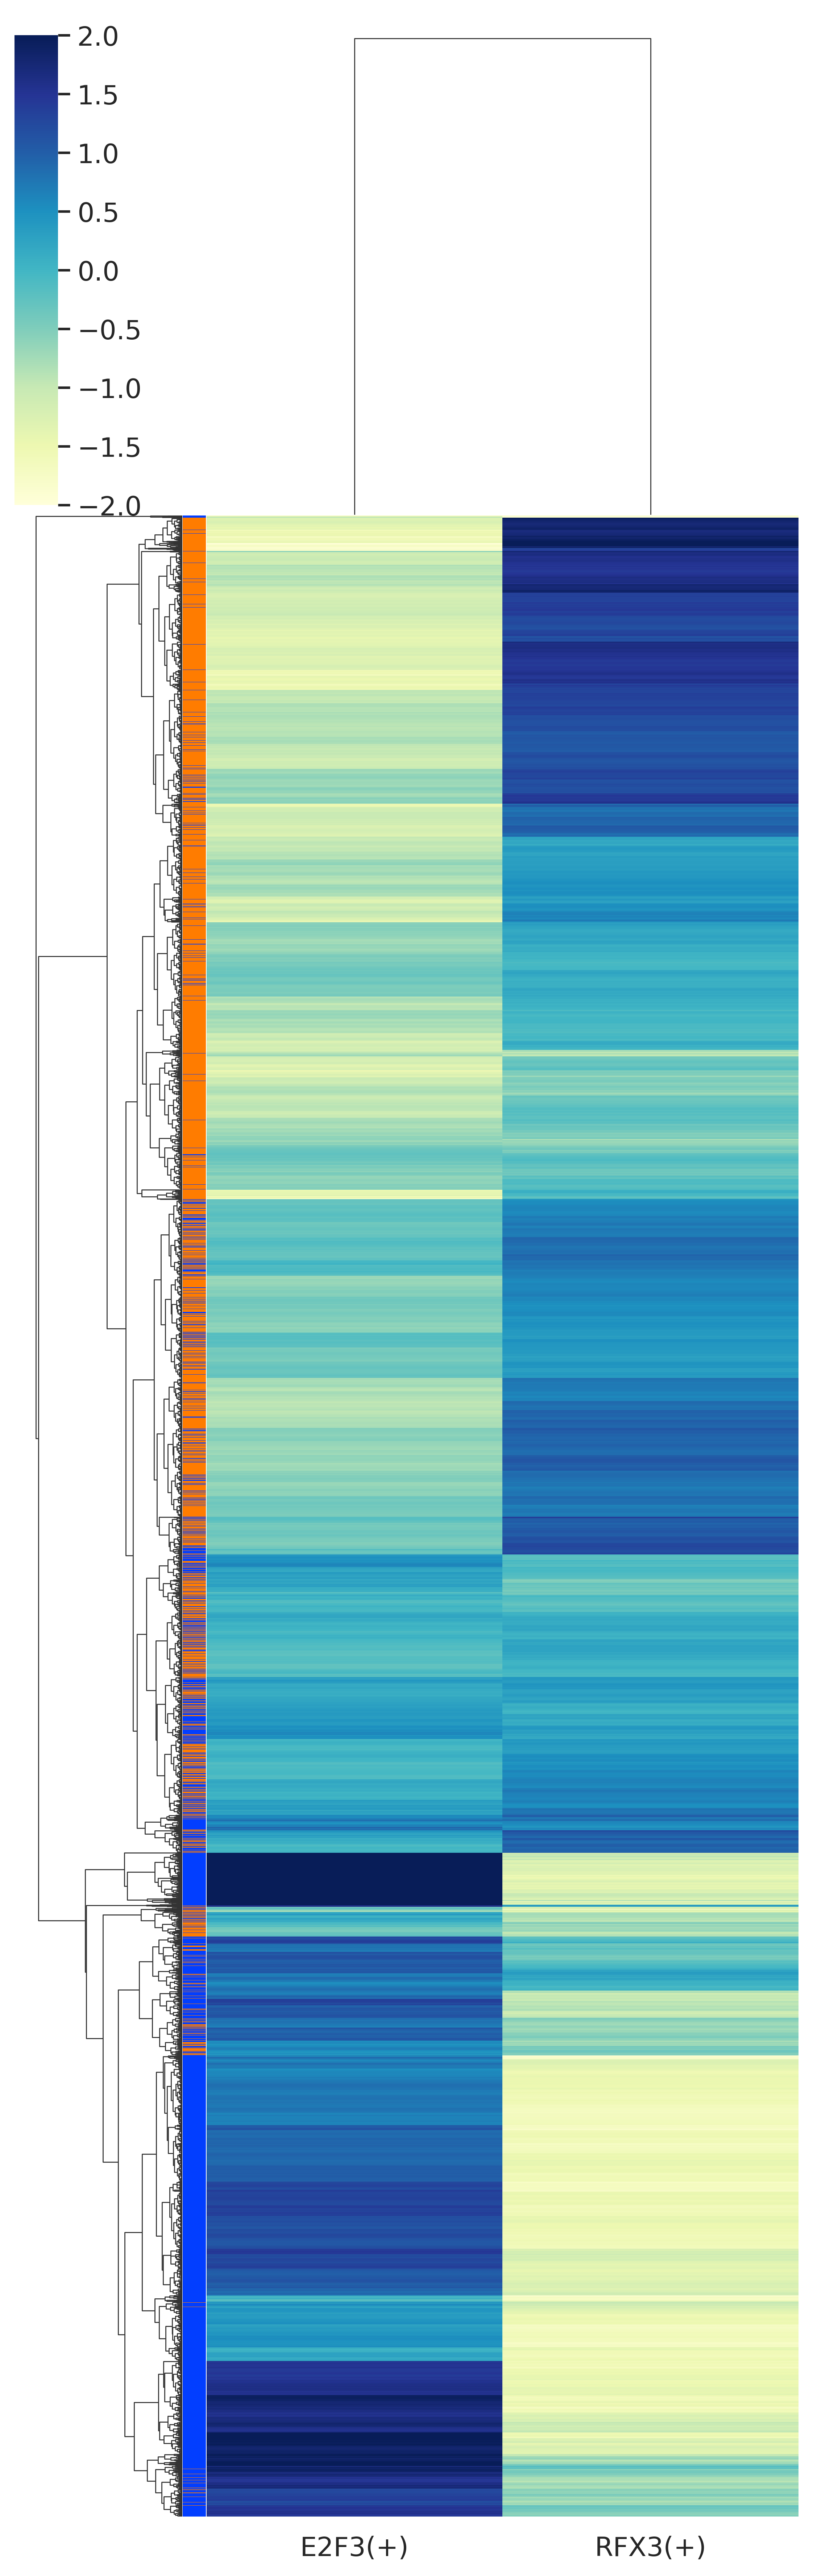

In [32]:
sns.set(font_scale=1.2)
g = sns.clustermap(SCENIC_adata.to_df()[['E2F3(+)', 'RFX3(+)']], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=2, row_colors=colormap,
    cmap="YlGnBu", figsize=(6,18))
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
#plt.savefig("PBMC10k_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")
plt.savefig('figures/malignant_normal_ciliated_TF.pdf')

In [520]:
adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/all_cell/adata_all_cell_raw_with_anno_latest.h5ad')
adata = adata[adata.obs['lineage'].isin(['Epithelium'])]
adata = adata[adata.obs['cancer_type'] == 'LUAD']

#SCENIC_results = SCENIC_Epithelium_1.loc[adata.obs.index.tolist(), :].copy()
SCENIC_results = SCENIC_Epithelium_2.loc[adata.obs.index.tolist(), :].copy()
#SCENIC_results = SCENIC_Epithelium_3.loc[adata.obs.index.tolist(), :].copy()
SCENIC_adata = sc.AnnData(SCENIC_results)
SCENIC_adata.obs['Type'] = adata.obs['Type']
    
sc.pp.scale(SCENIC_adata)

/tmp/ipykernel_12536/1389633253.py:8: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  SCENIC_adata = sc.AnnData(SCENIC_results)


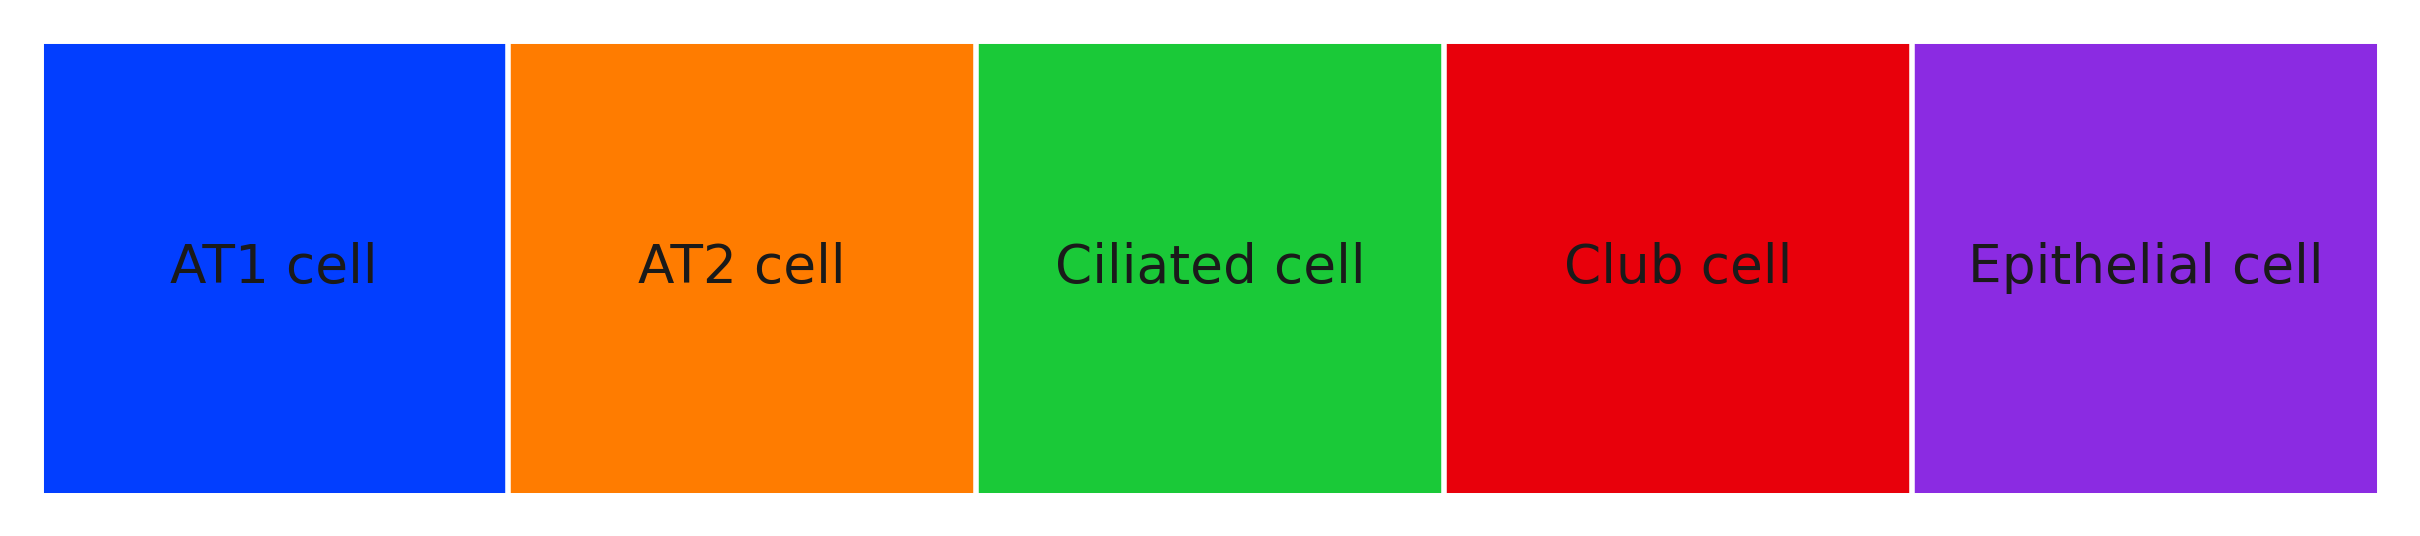

In [521]:
cats = np.unique(SCENIC_adata.obs['Type'])

colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in SCENIC_adata.obs['Type'] ]

sns.set()
sns.set(font_scale=0.8)
fig = palplot(colors, cats, size=1.5)

In [522]:
#[['TCF7(+)', 'FOXN4(+)', 'RFX3(+)', 'MYB(+)', 'MZF1(+)', 'IKZF2(+)', 'E2F7(+)']]

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


Text(0.5, 466.5000000000009, '')

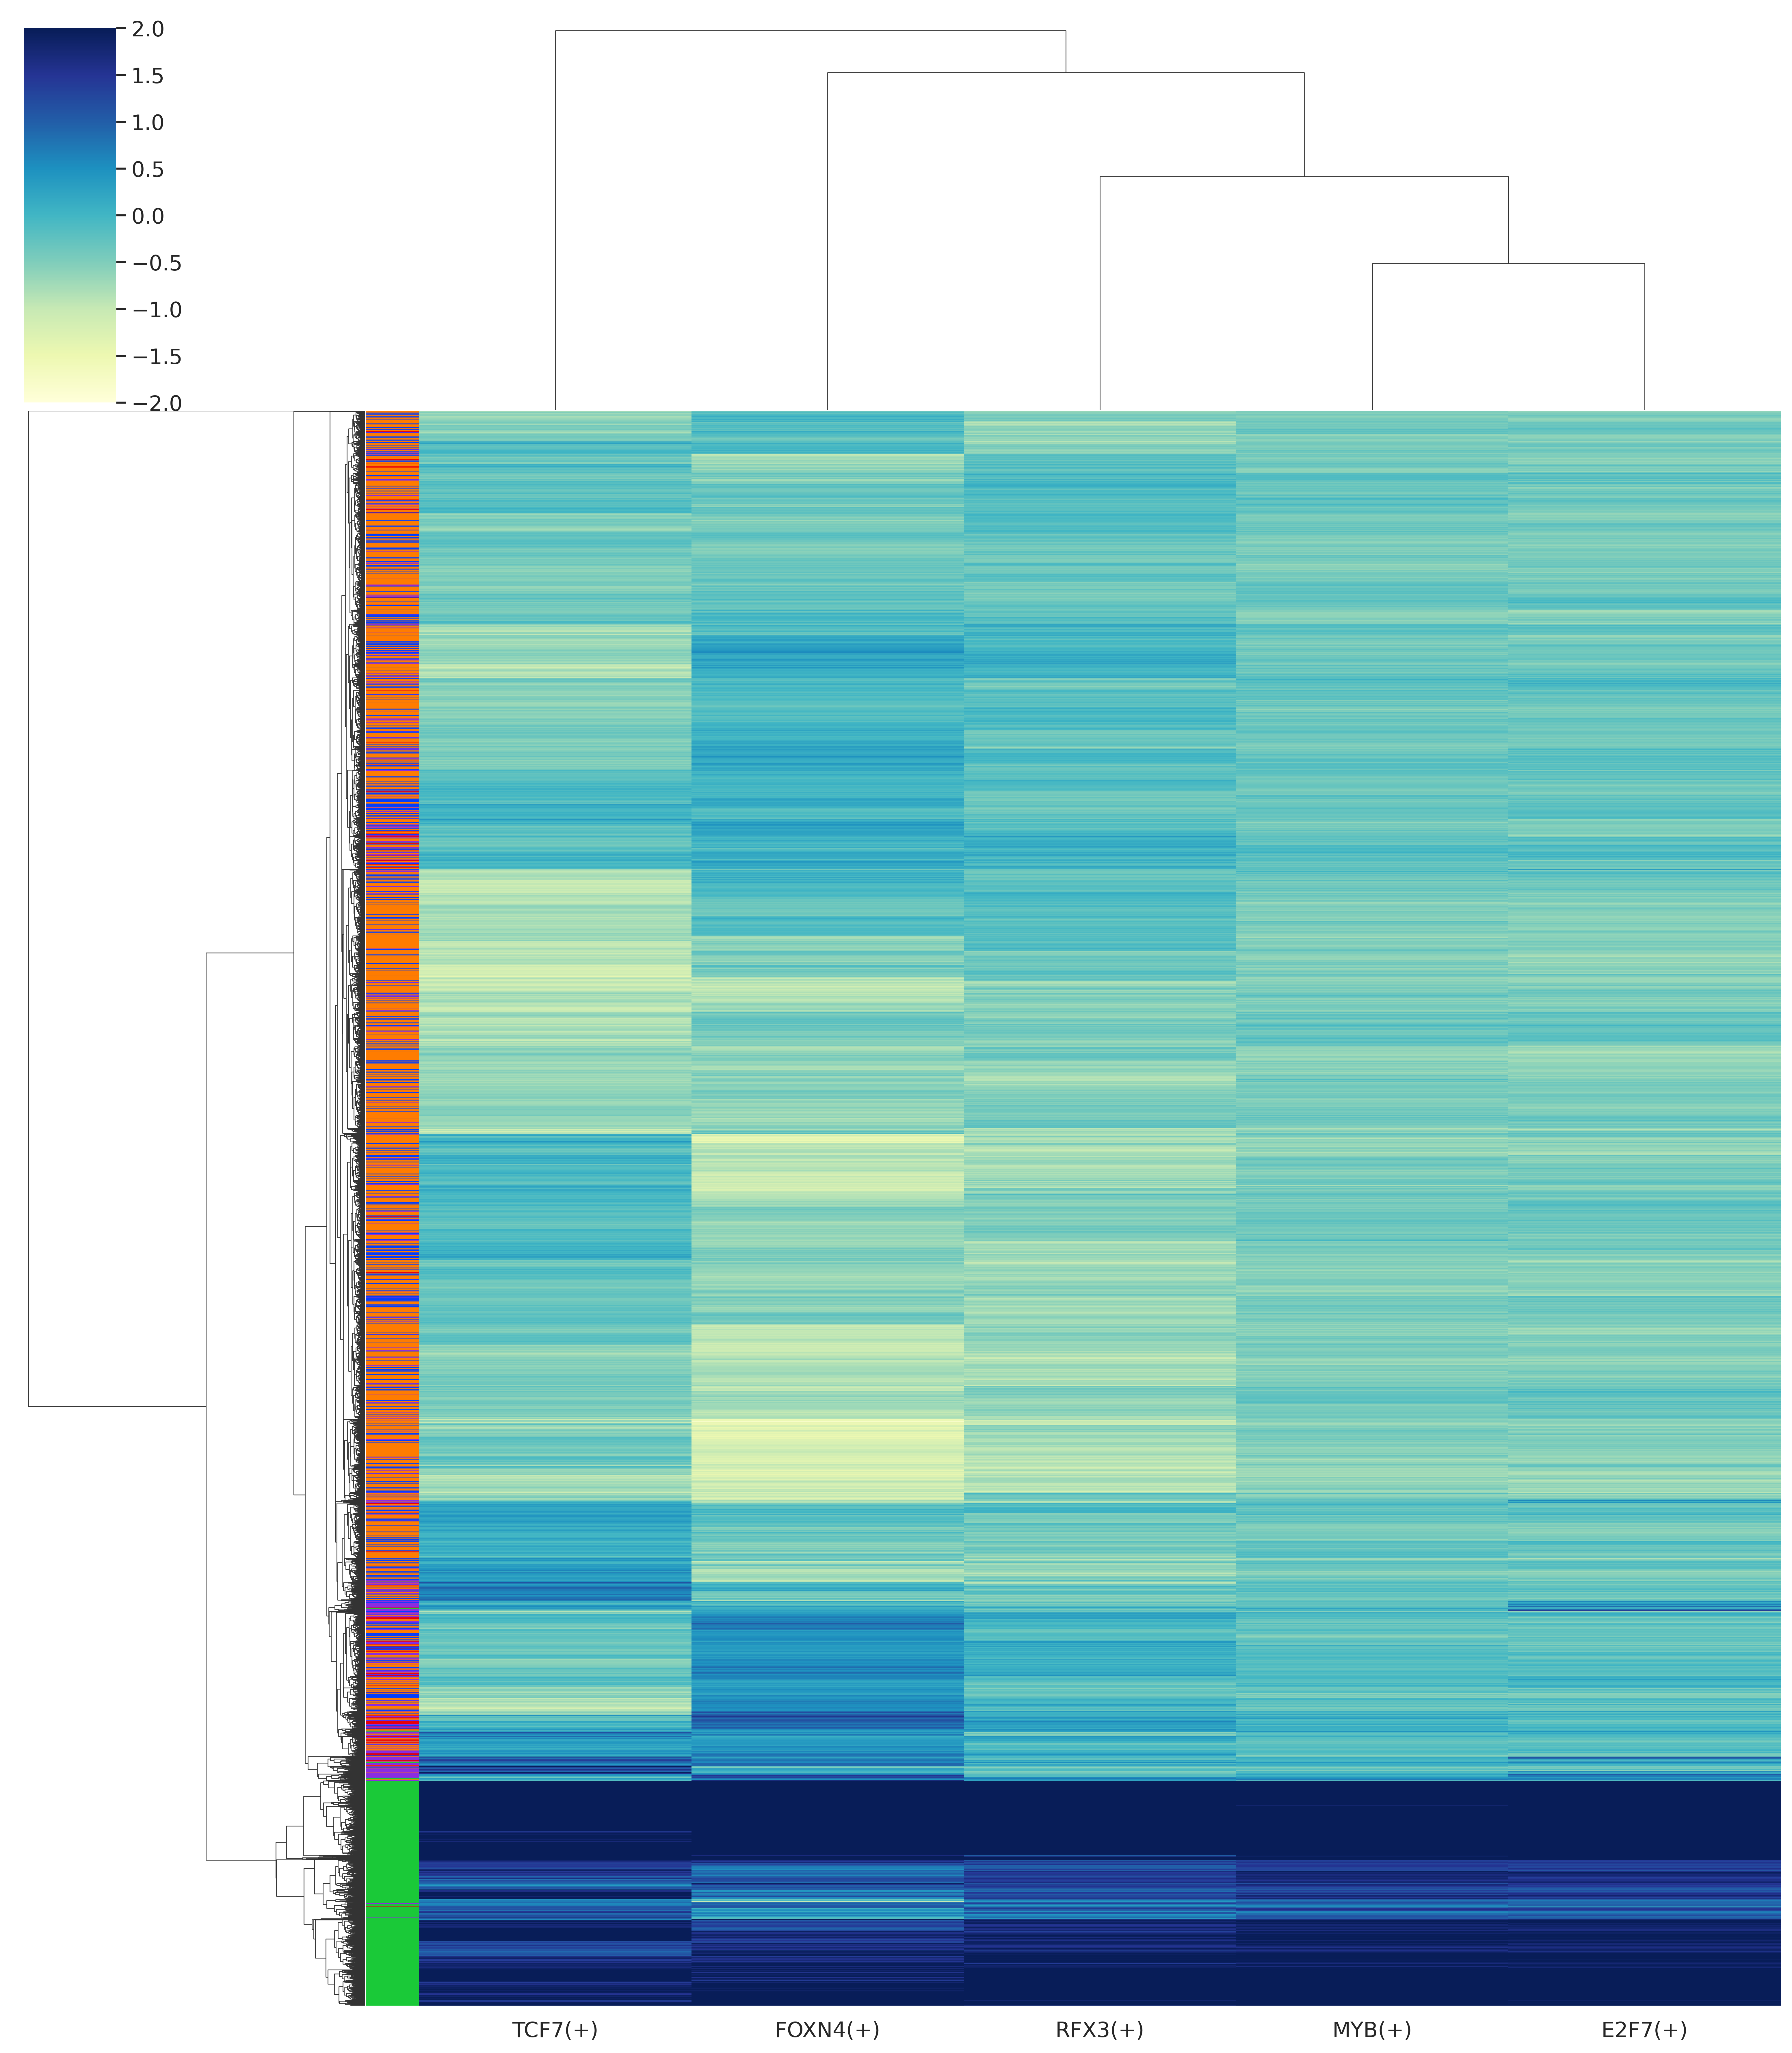

In [523]:
sns.set(font_scale=1.2)
g = sns.clustermap(SCENIC_adata.to_df()[['TCF7(+)', 'FOXN4(+)', 'RFX3(+)', 'MYB(+)', 'E2F7(+)']], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=2, row_colors=colormap,
    cmap="YlGnBu", figsize=(16,18))
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
#plt.savefig("PBMC10k_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")